# Donors Choose - Logistic regression

### <h2> <font color="blue">Importing packages</font></h3> 

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

### <h2> <font color="blue">Reading the data</font></h2> 

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

<h4> <font color="black">Project data</font></h4> 

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("Attributes :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
Attributes : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

<h3> <font color="blue">Handling Missing Value in "Teacher prefix" column</font></h3> 

In [4]:
a = project_data['teacher_prefix'].mode().values

In [5]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna(a[0])

In [6]:
#Total number of null values in each column
project_data.isnull().sum(axis = 0)

Unnamed: 0                                           0
id                                                   0
teacher_id                                           0
teacher_prefix                                       0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 105490
project_essay_4                                 105490
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
dtype: int64

<h4> <font color="black">Resource data</font></h4> 

In [7]:
print("Number of data points in train data", resource_data.shape)
print('-'*50)
print("Attributes: ", resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
--------------------------------------------------
Attributes:  ['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [8]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

<h3> <font color="blue">Preprocessing Categorical Data</font></h3> 

<h4> <font color="black">Project Subject Categories</font></h4> 

In [9]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

<h4> <font color="black">Project Subject Sub-Categories</font></h4>

In [10]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

<h3> <font color="blue">Preprocessing Text Data</font></h3> 

<h4> <font color="black">Project Essay</font></h4> 

In [11]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

 <h4> <font color="black">Compound Sentiment score of Project essay</font></h4> 

In [12]:
#https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

essays = project_data['essay']
essays_sentiments = []

for essay in tqdm(essays):
    res = sid.polarity_scores(essay)
    essays_sentiments.append(res['compound']) #Considering compound as a criteria.

project_data['essay_sentiment'] = essays_sentiments

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\VANSHIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [2:20:31<00:00, 172.47it/s]


In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

<h4> <font color="black">Word count of project essay and title</font></h4> 

In [14]:
for col_type, new_col in [('project_title', 'title_size'), ('essay', 'essay_size')]:
    col_data = project_data[col_type]
    col_size = []
    for sen in col_data:
        sen = decontracted(sen)
        col_size.append(len(sen.split()))
    project_data[new_col] = col_size

In [15]:
 project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  ...  \
55660  My students come from a variety of backgrounds...  ...   
76127  Most of my students have autism, anxiety, anot...  ...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

      teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                           53                    1   
76127                                            4                    1   

       clean_categories                 clean_subcategories  \
55660      Math_Science  AppliedSciences Health_LifeScience   
76127      SpecialNeeds                        SpecialNeeds   

                                                   essay essay_sentiment  \
55660  I have been fortunate enough to use the Fairy ...          0.9885   
76127  Imagine being 8-9 years old. You're in your th...          0.9950   

       title_size  essay_size  
55660           6         288  
76127           4         349  

[2 rows x 21 columns]

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.lower()
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split(" ") if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [02:10<00:00, 837.78it/s]


In [17]:
# placing the preprocessed essay into the dataframe
project_data['clean_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [18]:
#Printing random cleaned essay
project_data['clean_essays'].values[23]

'everyday students interact technology enhance learning experience days technology not available classroom ipad minis would technology count students diverse group whose learning needs range need individualized attention master concepts require additional extension maintain interest love learn explore students experiences technology range students whose experience school fluent use devices home students enthusiastic learning particularly excited learning together lot collaborative learning order experience like work team since team work wave future students love learn work teams use ipad minis protective cases dig research use qr codes apps learning not benefits technology affords also learn important social skills sharing working together developing leaders learned work hard collaborate groups addition two ipads classroom students opportunity use technology frequently enhance learning especially true little no technology home compete 21st century need level playing field everyone stud

<h4> <font color="black">Project title</font></h4> 

In [19]:
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.lower()
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:06<00:00, 18010.28it/s]


In [20]:
# placing the preprocessed essay into the dataframe
project_data['clean_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)

In [21]:
#Printing random cleaned title
project_data['clean_titles'].values[12]

'robots taking 2nd grade'

<h3> <font color="blue">Merging Price and quantity data to Project data (left joining price data)</font></h3> 

In [22]:
# reference : https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [23]:
# join two dataframes(project_data and price_data) in python
# reference : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
project_data = pd.merge(project_data, price_data, on='id', how='left')

<h3> <font color="blue">Splitting Data and Starifying the sampling</font></h3> 

In [24]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

print(X.shape)
print(y.shape)

(109248, 18)
(109248,)


In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify = y_train) # this is random splitting

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(49041, 18) (49041,)
(24155, 18) (24155,)
(36052, 18) (36052,)


<h3> <font color="blue">Vectorizing Categorical Data</font></h3> 

<h4> <font color="black">Clean Categories</font></h4> 

In [26]:
# we use count vectorizer to convert the values into one hot encoded features

# Vectorizing "clean_categories"
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_sbj = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sbj.fit(X_train['clean_categories'].values)

X_train_categories_one_hot = vectorizer_sbj.transform(X_train['clean_categories'].values)
X_cv_categories_one_hot = vectorizer_sbj.transform(X_cv['clean_categories'].values)
X_test_categories_one_hot = vectorizer_sbj.transform(X_test['clean_categories'].values)

print("After verctorizing")
print(X_train_categories_one_hot.shape, y_train.shape)
print(X_cv_categories_one_hot.shape, y_cv.shape)
print(X_test_categories_one_hot.shape, y_test.shape)

print(vectorizer_sbj.get_feature_names())

After verctorizing
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


<h4> <font color="black">Clean sub Categories</font></h4> 

In [27]:
# Vectorizing "clean_subcategories"
vectorizer_sub_sbj = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub_sbj.fit(X_train['clean_subcategories'].values)

X_train_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_train['clean_subcategories'].values)
X_cv_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_cv['clean_subcategories'].values)
X_test_sub_categories_one_hot = vectorizer_sub_sbj.transform(X_test['clean_subcategories'].values)

print("After verctorizing")
print(X_train_sub_categories_one_hot.shape, y_train.shape)
print(X_cv_sub_categories_one_hot.shape, y_cv.shape)
print(X_test_sub_categories_one_hot.shape, y_test.shape)

print(vectorizer_sub_sbj.get_feature_names())

After verctorizing
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


<h4> <font color="black">Teacher Prefix</font></h4> 

In [28]:
# Vectorizing "teacher_prefix"
prefix = list(set(X_train['teacher_prefix'].values))

vectorizer_teacher = CountVectorizer(vocabulary=prefix, lowercase=False, binary=True)
vectorizer_teacher.fit(X_train['teacher_prefix'].values)

X_train_prefix_one_hot = vectorizer_teacher.transform(X_train['teacher_prefix'])
X_cv_prefix_one_hot = vectorizer_teacher.transform(X_cv['teacher_prefix'])
X_test_prefix_one_hot = vectorizer_teacher.transform(X_test['teacher_prefix'])

print("After verctorizing")
print(X_train_prefix_one_hot.shape, y_train.shape)
print(X_cv_prefix_one_hot.shape, y_cv.shape)
print(X_test_prefix_one_hot.shape, y_test.shape)

print(vectorizer_teacher.get_feature_names())

After verctorizing
(49041, 5) (49041,)
(24155, 5) (24155,)
(36052, 5) (36052,)
['Dr.', 'Ms.', 'Teacher', 'Mr.', 'Mrs.']


<h4> <font color="black">school state</font></h4> 

In [29]:
# Vectorizing "school_state"
from collections import Counter
my_counter = Counter()
for word in X_train['school_state'].values:
    my_counter.update(word.split())
    
state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1]))

vectorizer_state = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer_state.fit(X_train['school_state'].values)

X_train_state_one_hot = vectorizer_state.transform(X_train['school_state'].values)
X_cv_state_one_hot = vectorizer_state.transform(X_cv['school_state'].values)
X_test_state_one_hot = vectorizer_state.transform(X_test['school_state'].values)

print("After verctorizing")
print(X_train_state_one_hot.shape, y_train.shape)
print(X_cv_state_one_hot.shape, y_cv.shape)
print(X_test_state_one_hot.shape, y_test.shape)

print(vectorizer_state.get_feature_names())

After verctorizing
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'HI', 'DC', 'ME', 'NM', 'WV', 'KS', 'IA', 'ID', 'AR', 'CO', 'KY', 'MN', 'OR', 'MS', 'NV', 'MD', 'CT', 'TN', 'WI', 'UT', 'AL', 'VA', 'AZ', 'NJ', 'WA', 'OK', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


<h4> <font color="black">Project Grade Category</font></h4> 

In [30]:
# Vectorizing "project_grade_category"
prefix = list(set(X_train["project_grade_category"].values))

vectorizer_grade = CountVectorizer(vocabulary=prefix, lowercase=False, binary=True)
vectorizer_grade.fit(X_train['project_grade_category'])

X_train_grade_one_hot = vectorizer_grade.transform(X_train['project_grade_category'])
X_cv_grade_one_hot = vectorizer_grade.transform(X_cv['project_grade_category'])
X_test_grade_one_hot = vectorizer_grade.transform(X_test['project_grade_category'])

print("After verctorizing")
print(X_train_grade_one_hot.shape, y_train.shape)
print(X_cv_grade_one_hot.shape, y_cv.shape)
print(X_test_grade_one_hot.shape, y_test.shape)

print(vectorizer_grade.get_feature_names())

After verctorizing
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['Grades 6-8', 'Grades PreK-2', 'Grades 9-12', 'Grades 3-5']


<h3> <font color="blue">Normalizing Numerical values</font></h3> 

<h4> <font color="black">Number of previously posted assignments by Teacher</font></h4> 

In [31]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

number_projects_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
number_projects_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
number_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(number_projects_train.shape, y_train.shape)
print(number_projects_cv.shape, y_cv.shape)
print(number_projects_test.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [32]:
number_projects_train

array([[0.        , 0.00358822, 0.00029902, ..., 0.00059804, 0.00224264,
        0.00044853]])

In [33]:
number_projects_train = np.reshape(number_projects_train, (-1, 1))
number_projects_cv = np.reshape(number_projects_cv, (-1, 1))
number_projects_test = np.reshape(number_projects_test, (-1, 1))

<h4> <font color="black">Price</font></h4> 

In [34]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

price_train = normalizer.transform(X_train['price'].values.reshape(1,-1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(1,-1))
price_test = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(price_train.shape, y_train.shape)
print(price_cv.shape, y_cv.shape)
print(price_test.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [35]:
price_train

array([[0.00012928, 0.00102169, 0.00181487, ..., 0.00011796, 0.003535  ,
        0.00095082]])

In [36]:
price_train=np.reshape(price_train, (-1, 1))
price_cv=np.reshape(price_cv, (-1, 1))
price_test=np.reshape(price_test, (-1, 1))

<h4> <font color="black">Resource quantity</font></h4> 

In [37]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(1,-1))

quantity_train = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
quantity_test = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(quantity_train.shape, y_train.shape) 
print(quantity_cv.shape, y_cv.shape)
print(quantity_test.shape, y_test.shape)

After vectorizations
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [38]:
quantity_train 

array([[0.00145311, 0.00058124, 0.00319684, ..., 0.00726555, 0.00101718,
        0.00029062]])

In [39]:
quantity_train =np.reshape(quantity_train, (-1, 1))
quantity_cv =np.reshape(quantity_cv, (-1, 1))
quantity_test =np.reshape(quantity_test, (-1, 1))

<h4> <font color="black">Sentiment score</font></h4> 

In [40]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

essay_sentiment_train = X_train['essay_sentiment'].values.reshape(1,-1)
essay_sentiment_cv = X_cv['essay_sentiment'].values.reshape(1,-1)
essay_sentiment_test = X_test['essay_sentiment'].values.reshape(1,-1)

essay_sentiment_train = np.reshape(essay_sentiment_train, (-1, 1))
essay_sentiment_cv = np.reshape(essay_sentiment_cv, (-1, 1))
essay_sentiment_test = np.reshape(essay_sentiment_test, (-1, 1))

print(essay_sentiment_train.shape,y_train.shape)
print(essay_sentiment_cv.shape ,y_cv.shape)
print(essay_sentiment_test.shape,  y_test.shape)


(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


<h4> <font color="black">Number of words in Project title</font></h4> 

In [41]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['title_size'].values.reshape(1,-1))

title_size_train = normalizer.transform(X_train['title_size'].values.reshape(1,-1))
title_size_cv = normalizer.transform(X_cv['title_size'].values.reshape(1,-1))
title_size_test = normalizer.transform(X_test['title_size'].values.reshape(1,-1))

print("After normalization")
print(title_size_train.shape, y_train.shape)
print(title_size_cv.shape, y_cv.shape)
print(title_size_test.shape, y_test.shape)

After normalization
(1, 49041) (49041,)
(1, 24155) (24155,)
(1, 36052) (36052,)


In [42]:
title_size_train =np.reshape(title_size_train, (-1, 1))
title_size_cv =np.reshape(title_size_cv, (-1, 1))
title_size_test =np.reshape(title_size_test, (-1, 1))

print(title_size_train.shape, y_train.shape)
print(title_size_cv.shape, y_cv.shape)
print(title_size_test.shape, y_test.shape)

(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


<h4> <font color="black">Number of words in combined Essay</font></h4> 

In [43]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['essay_size'].values.reshape(1,-1))

essay_size_train = normalizer.transform(X_train['essay_size'].values.reshape(1,-1))
essay_size_cv = normalizer.transform(X_cv['essay_size'].values.reshape(1,-1))
essay_size_test = normalizer.transform(X_test['essay_size'].values.reshape(1,-1))

essay_size_train =np.reshape(essay_size_train, (-1, 1))
essay_size_cv =np.reshape(essay_size_cv, (-1, 1))
essay_size_test =np.reshape(essay_size_test, (-1, 1))


print(essay_size_train.shape, y_train.shape)
print(essay_size_cv.shape, y_cv.shape)
print(essay_size_test.shape, y_test.shape)

(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


<h3> <font color="blue">BoW</font></h3> 

<h4> <font color="black">BoW on Clean Essay</font></h4> 

In [44]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_bow_essay = CountVectorizer(min_df=10, max_features = 5000, ngram_range=(2, 2))
vectorizer_bow_essay.fit(X_train['clean_essays'].values)

X_train_essay_bow = vectorizer_bow_essay.transform(X_train['clean_essays'].values)
X_cv_essay_bow = vectorizer_bow_essay.transform(X_cv['clean_essays'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['clean_essays'].values)

print("After vectorizing")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

After vectorizing
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


<h4> <font color="black">BoW on Clean Title</font></h4> 

In [45]:
vectorizer_bow_title = CountVectorizer(min_df=10, ngram_range=(2, 2))
vectorizer_bow_title.fit(X_train['clean_titles'].values)

X_train_titles_bow = vectorizer_bow_title.transform(X_train['clean_titles'].values)
X_cv_titles_bow = vectorizer_bow_title.transform(X_cv['clean_titles'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['clean_titles'].values)

print("After vectorizing")
print(X_train_titles_bow.shape, y_train.shape)
print(X_cv_titles_bow.shape, y_cv.shape)
print(X_test_titles_bow.shape, y_test.shape)

After vectorizing
(49041, 1215) (49041,)
(24155, 1215) (24155,)
(36052, 1215) (36052,)


<h3> <font color="blue">Tfidf vectorization of text data</font></h3> 

<h4> <font color="black">Tfidf on Clean Essay</font></h4> 

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer_tfidf_essay = TfidfVectorizer(min_df=10, max_features = 5000, ngram_range=(2, 2))
vectorizer_tfidf_essay.fit(X_train['clean_essays'].values)

X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['clean_essays'])
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['clean_essays'])
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['clean_essays'])

print("After vectorizing")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizing
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


<h4> <font color="black">Tfidf on Clean Title</font></h4> 

In [47]:
vectorizer_tfidf_title = TfidfVectorizer(min_df=10, ngram_range=(2, 2))
vectorizer_tfidf_title.fit(X_train['clean_titles'].values)

X_train_title_tfidf = vectorizer_tfidf_title.transform(X_train['clean_titles'])
X_cv_title_tfidf = vectorizer_tfidf_title.transform(X_cv['clean_titles'])
X_test_title_tfidf = vectorizer_tfidf_title.transform(X_test['clean_titles'])

print("After vectorizing")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

After vectorizing
(49041, 1215) (49041,)
(24155, 1215) (24155,)
(36052, 1215) (36052,)


<h3> <font color="blue">Avg W2V</font></h3> 

In [48]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))

for i in preprocessed_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)
    
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

Loading Glove Model


1917495it [09:03, 3529.80it/s]


Done. 1917495  words loaded!
all the words in the coupus 15495364
the unique words in the coupus 58829
The number of words that are present in both glove vectors and our coupus 51363 ( 87.309 %)
word 2 vec length 51363


<h4> <font color="black">Avg W2V on Clean Essay</font></h4> 

In [49]:
train_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_essay_avg_w2v.append(vector)

print(len(train_essay_avg_w2v))
print(len(train_essay_avg_w2v[0]))


cv_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_essay_avg_w2v.append(vector)

print(len(cv_essay_avg_w2v))
print(len(cv_essay_avg_w2v[0]))


test_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in words_glove:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_essay_avg_w2v.append(vector)

print(len(test_essay_avg_w2v))
print(len(test_essay_avg_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [00:31<00:00, 1560.55it/s]


49041
300


100%|██████████████████████████████████████████████████████████████████████████| 24155/24155 [00:14<00:00, 1616.77it/s]


24155
300


100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:22<00:00, 1595.16it/s]


36052
300


In [50]:
# Changing list to numpy arrays
train_essay_avg_w2v = np.array(train_essay_avg_w2v)
cv_essay_avg_w2v = np.array(cv_essay_avg_w2v)
test_essay_avg_w2v = np.array(test_essay_avg_w2v)

<h4> <font color="black">Avg W2V on Clean Title</font></h4> 

In [51]:
train_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_title_avg_w2v.append(vector)

print(len(train_title_avg_w2v))
print(len(train_title_avg_w2v[0]))


cv_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_title_avg_w2v.append(vector)

print(len(cv_title_avg_w2v))
print(len(cv_title_avg_w2v[0]))


test_title_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_title_avg_w2v.append(vector)

print(len(test_title_avg_w2v))
print(len(test_title_avg_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:01<00:00, 32391.08it/s]


49041
300


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 33285.85it/s]


24155
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:01<00:00, 33800.23it/s]


36052
300


In [52]:
# Changing list to numpy arrays
train_title_avg_w2v = np.array(train_title_avg_w2v)
cv_title_avg_w2v = np.array(cv_title_avg_w2v)
test_title_avg_w2v = np.array(test_title_avg_w2v)

<h3> <font color="blue">Tfidf W2V</font></h3> 

<h4> <font color="black">Tfidf W2V on Clean essay</font></h4> 

In [53]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['clean_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [54]:
train_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_essay_tfidf_w2v.append(vector)

print(len(train_essay_tfidf_w2v))
print(len(train_essay_tfidf_w2v[0]))


cv_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_essay_tfidf_w2v.append(vector)

print(len(cv_essay_tfidf_w2v))
print(len(cv_essay_tfidf_w2v[0]))


test_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_essay_tfidf_w2v.append(vector)

print(len(test_essay_tfidf_w2v))
print(len(test_essay_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49041/49041 [1:40:39<00:00,  8.12it/s]


49041
300


100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:42<00:00, 234.66it/s]


24155
300


100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [02:33<00:00, 234.27it/s]


36052
300


In [55]:
# Changing list to numpy arrays
train_essay_tfidf_w2v = np.array(train_essay_tfidf_w2v)
cv_essay_tfidf_w2v = np.array(cv_essay_tfidf_w2v)
test_essay_tfidf_w2v = np.array(test_essay_tfidf_w2v)

<h4> <font color="black">Tfidf W2V on Clean Title</font></h4> 

In [56]:
train_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_title_tfidf_w2v.append(vector)

print(len(train_title_tfidf_w2v))
print(len(train_title_tfidf_w2v[0]))


cv_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_title_tfidf_w2v.append(vector)

print(len(cv_title_tfidf_w2v))
print(len(cv_title_tfidf_w2v[0]))



test_title_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['clean_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_title_tfidf_w2v.append(vector)

print(len(test_title_tfidf_w2v))
print(len(test_title_tfidf_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:03<00:00, 12729.67it/s]


49041
300


100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 16642.59it/s]


24155
300


100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:02<00:00, 16751.37it/s]


36052
300


In [57]:
# Changing list to numpy arrays
train_title_tfidf_w2v = np.array(train_title_tfidf_w2v)
cv_title_tfidf_w2v = np.array(cv_title_tfidf_w2v)
test_title_tfidf_w2v = np.array(test_title_tfidf_w2v)

<h2> <font color="blue">Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and `max_features=5000`)</font></h2>

<h4> <font color="black">Hstacking features</font></h4> 

In [58]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)+++
X_train_bow = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, X_train_essay_bow, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, X_train_titles_bow, price_train, number_projects_train)).tocsr()
X_cv_bow = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, X_cv_essay_bow, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, X_cv_titles_bow, price_cv, number_projects_cv)).tocsr()
X_test_bow = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, X_test_essay_bow, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, X_test_titles_bow, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

Final matrix
(49041, 6317) (49041,)
(24155, 6317) (24155,)
(36052, 6317) (36052,)


In [59]:
def batch_predict(clf, data):
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000  #Iter untill last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

<h4> <font color="black">Hyperparameter tuning using simple for loop</font></h4> 

In [60]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []


alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000]  #Taking random values of alpha

for i in tqdm(alphas):
    sgd_bow = SGDClassifier(alpha=i, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
           verbose=0, warm_start=False)
    sgd_bow.fit(X_train_bow, y_train)

    y_train_pred = batch_predict(sgd_bow, X_train_bow )    
    y_cv_pred = batch_predict(sgd_bow, X_cv_bow)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 522.85it/s]


<h4> <font color="black">log_alphas vs AUC</font></h4> 

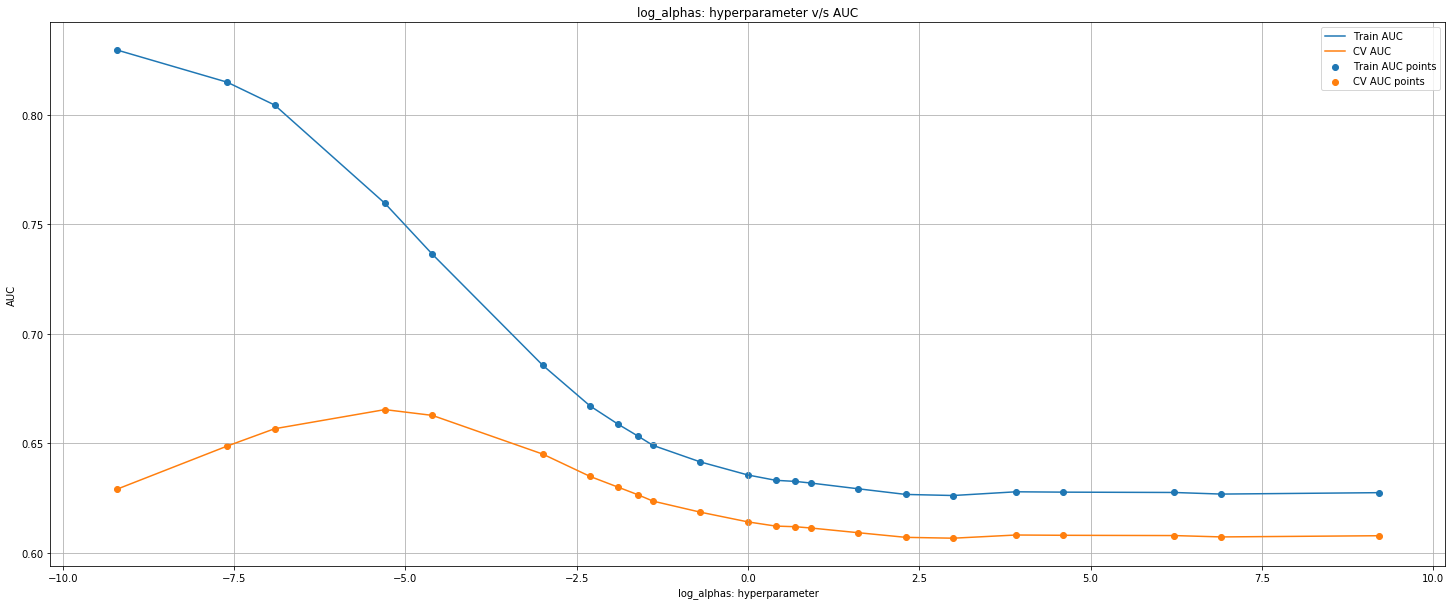

In [61]:
plt.figure(figsize=(25,10))

plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("log_alphas: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [62]:
optimal_alpha = 0.005

<h4> <font color="black">Training model with optimal value of hyperparameter</font></h4> 

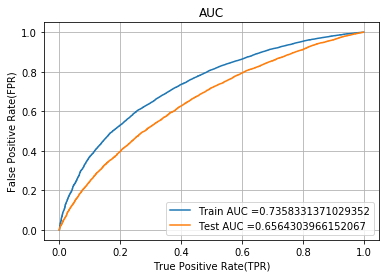

In [63]:
from sklearn.metrics import roc_curve, auc

sgd_bow = SGDClassifier(alpha=optimal_alpha, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
          random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False)

sgd_bow.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(sgd_bow, X_train_bow)    
y_test_pred = batch_predict(sgd_bow, X_test_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<h4> <font color="black">Getting confusion metrix for both train and test set</font></h4> 

In [64]:
def get_confusion_matrix(clf,X_te,y_test):
    y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

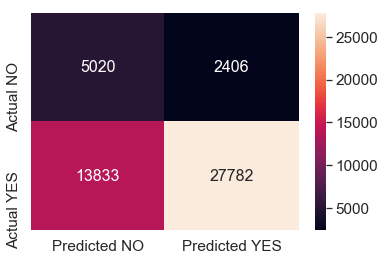

In [65]:
get_confusion_matrix(sgd_bow,X_train_bow,y_train)

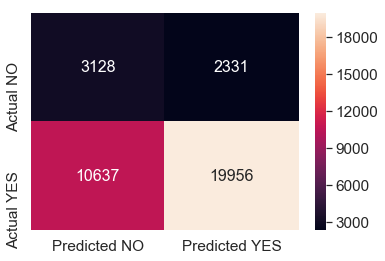

In [66]:
get_confusion_matrix(sgd_bow,X_test_bow,y_test)

<h4> <font color="black">Evaluating model performance</font></h4> 

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = sgd_bow.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 64.030%
Precision on test set: 0.895
Recall on test set: 0.652
F1-Score on test set: 0.755


<h2><font color='blue'>Set 2: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)</font></h2>

<h4> <font color="black">Hstacking features</font></h4> 

In [68]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_tfidf = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, X_train_essay_tfidf, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, X_train_title_tfidf, price_train, number_projects_train)).tocsr()
X_cv_tfidf = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, X_cv_essay_tfidf, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, X_cv_title_tfidf, price_cv, number_projects_cv)).tocsr()
X_test_tfidf = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, X_test_essay_tfidf, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, X_test_title_tfidf, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

Final matrix
(49041, 6317) (49041,)
(24155, 6317) (24155,)
(36052, 6317) (36052,)


<h4> <font color="black">Hyperparameter tuning</font></h4> 

In [69]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000] #Taking random values of alpha

for i in tqdm(alphas):
    sgd_tfidf = SGDClassifier(alpha=i, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
           verbose=0, warm_start=False)
    sgd_tfidf.fit(X_train_tfidf, y_train)

    y_train_pred = batch_predict(sgd_tfidf, X_train_tfidf )    
    y_cv_pred = batch_predict(sgd_tfidf, X_cv_tfidf)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


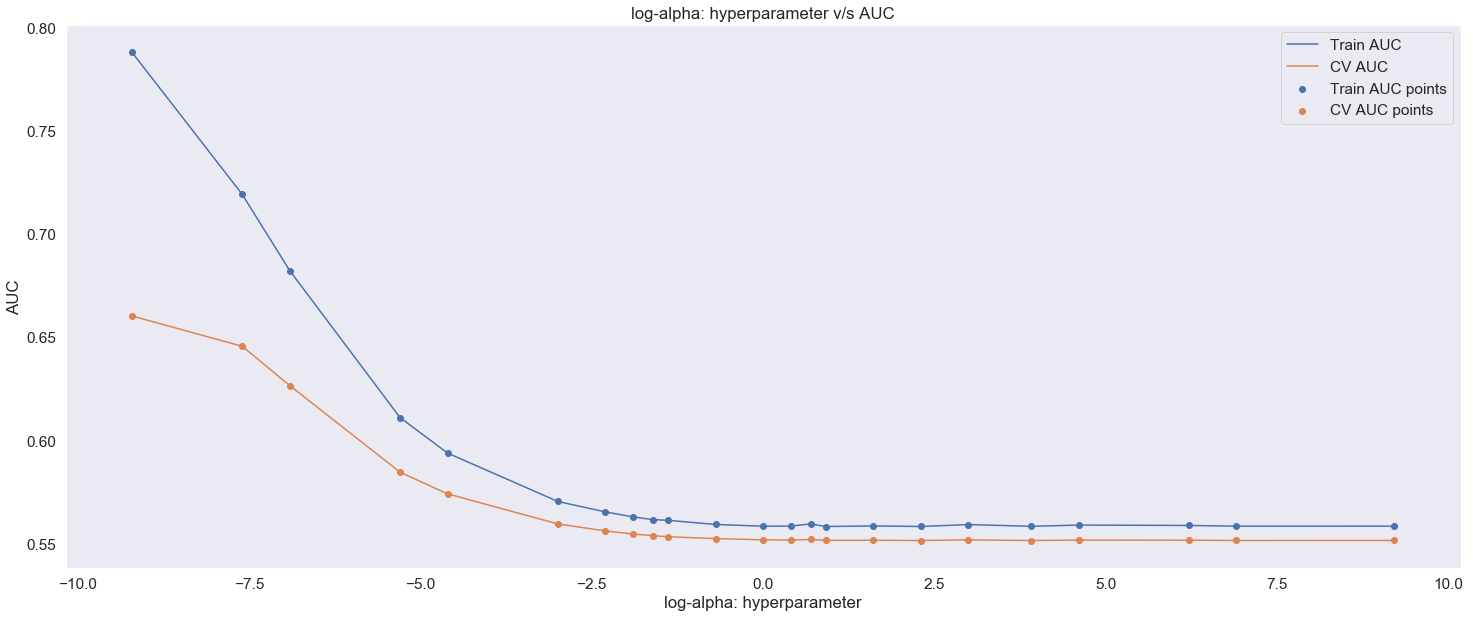

In [70]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [71]:
optimal_alpha  = 0.005

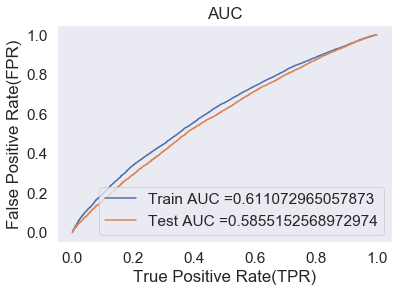

In [72]:
from sklearn.metrics import roc_curve, auc

sgd_tfidf = SGDClassifier(alpha=optimal_alpha, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
          random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False)

sgd_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(sgd_tfidf, X_train_tfidf)    
y_test_pred = batch_predict(sgd_tfidf, X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<h4> <font color="black">Confusion matrix</font></h4> 

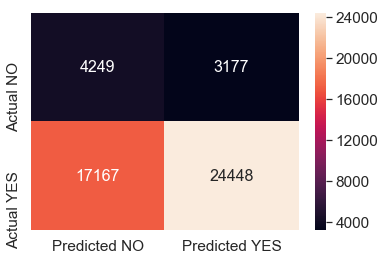

In [73]:
get_confusion_matrix(sgd_tfidf,X_train_tfidf,y_train)

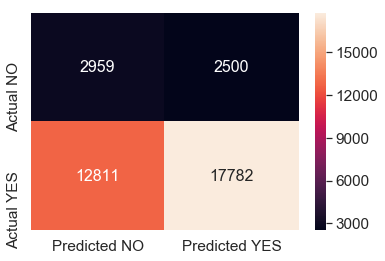

In [74]:
get_confusion_matrix(sgd_tfidf,X_test_tfidf,y_test)

<h4> <font color="black">Evaluating model performance</font></h4> 

In [75]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = sgd_tfidf.predict(X_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 57.531%
Precision on test set: 0.877
Recall on test set: 0.581
F1-Score on test set: 0.699


<h2><font color='blue'>Set 3: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</font></h2>

<h4> <font color="black">Hstacking features</font></h4> 

In [76]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_avg = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, train_essay_avg_w2v, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, train_title_avg_w2v, price_train, number_projects_train)).tocsr()
X_cv_avg = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, cv_essay_avg_w2v, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, cv_title_avg_w2v, price_cv, number_projects_cv)).tocsr()
X_test_avg = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, test_essay_avg_w2v, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, test_title_avg_w2v, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_avg.shape, y_train.shape)
print(X_cv_avg.shape, y_cv.shape)
print(X_test_avg.shape, y_test.shape)

Final matrix
(49041, 702) (49041,)
(24155, 702) (24155,)
(36052, 702) (36052,)


<h4> <font color="black">Hyperparameter Tuning</font></h4> 

In [77]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000] #Taking random values of alpha

for i in tqdm(alphas):
    sgd_avg = SGDClassifier(alpha=i, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
           verbose=0, warm_start=False)
    sgd_avg.fit(X_train_avg, y_train)

    y_train_pred = batch_predict(sgd_avg, X_train_avg )    
    y_cv_pred = batch_predict(sgd_avg, X_cv_avg)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


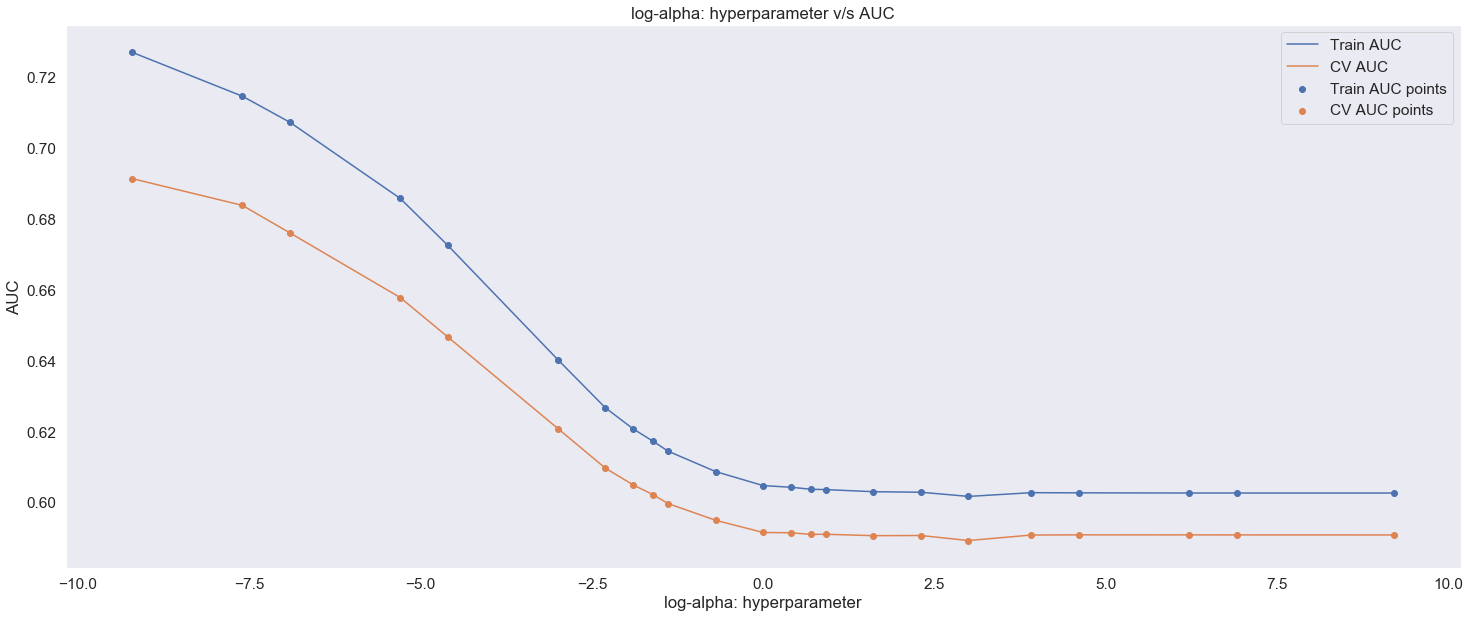

In [78]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [79]:
optimal_alpha = 0.005

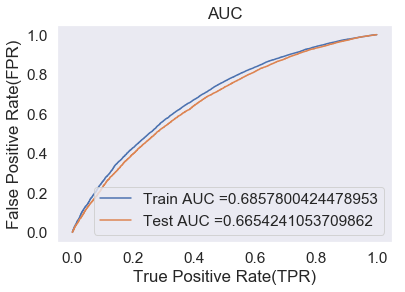

In [80]:
from sklearn.metrics import roc_curve, auc

sgd_avg = SGDClassifier(alpha=optimal_alpha, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
          random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False)

sgd_avg.fit(X_train_avg, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(sgd_avg, X_train_avg)    
y_test_pred = batch_predict(sgd_avg, X_test_avg)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<h4> <font color="black">Confusion matrix</font></h4> 

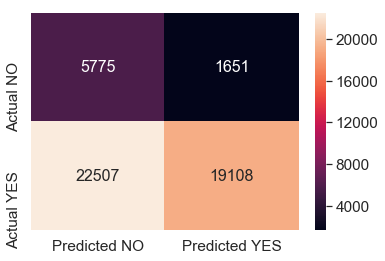

In [81]:
get_confusion_matrix(sgd_avg,X_train_avg,y_train)

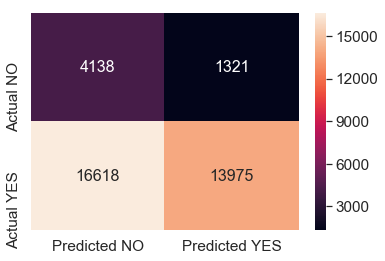

In [82]:
get_confusion_matrix(sgd_avg,X_test_avg,y_test)

<h4> <font color="black">Evaluating model performance</font></h4> 

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = sgd_avg.predict(X_test_avg)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 50.241%
Precision on test set: 0.914
Recall on test set: 0.457
F1-Score on test set: 0.609


<h2><font color='blue'>Set 4: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</font></h2>   

<h4> <font color="black">Hstacking features</font></h4> 

In [84]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_tfidf_w2v = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot, train_essay_tfidf_w2v, quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, train_title_tfidf_w2v, price_train, number_projects_train)).tocsr()
X_cv_tfidf_w2v = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, cv_essay_tfidf_w2v, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, cv_title_tfidf_w2v, price_cv, number_projects_cv)).tocsr()
X_test_tfidf_w2v = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot, test_essay_tfidf_w2v, quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot, test_title_tfidf_w2v, price_test, number_projects_test)).tocsr()

print('Final matrix')
print(X_train_tfidf_w2v.shape, y_train.shape)
print(X_cv_tfidf_w2v.shape, y_cv.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)

Final matrix
(49041, 702) (49041,)
(24155, 702) (24155,)
(36052, 702) (36052,)


<h4> <font color="black">Hyperparameter tuning</font></h4> 

In [85]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000]   #Taking random values of alpha

for i in tqdm(alphas):
    sgd_tfidf_w2v = SGDClassifier(alpha=i, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
           verbose=0, warm_start=False)
    sgd_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)

    y_train_pred = batch_predict(sgd_tfidf_w2v, X_train_tfidf_w2v )    
    y_cv_pred = batch_predict(sgd_tfidf_w2v, X_cv_tfidf_w2v)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 5755.22it/s]


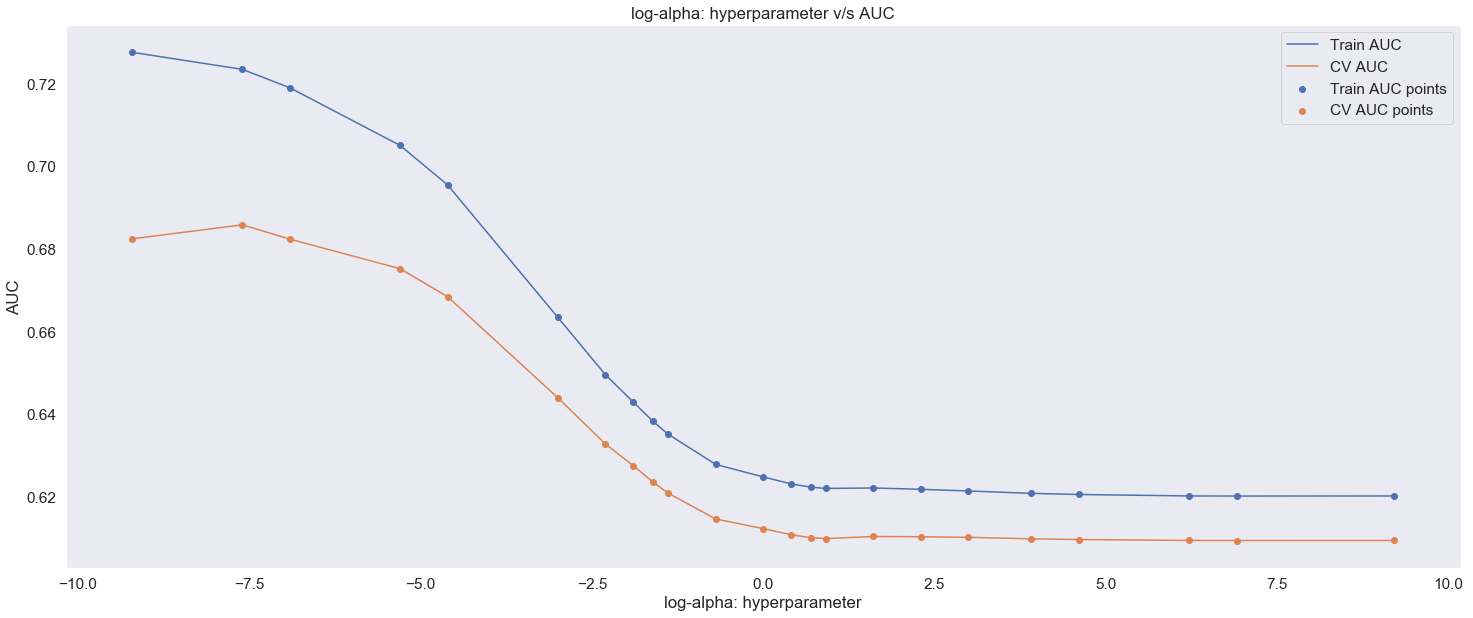

In [86]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [87]:
optimal_alpha = 0.005

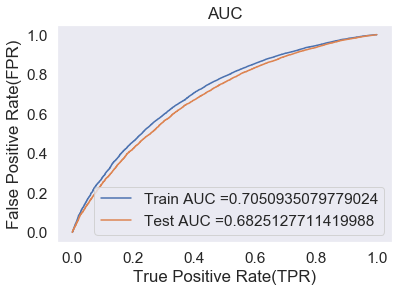

In [88]:
from sklearn.metrics import roc_curve, auc

sgd_tfidf_w2v = SGDClassifier(alpha=optimal_alpha, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
          random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False)

sgd_tfidf_w2v.fit(X_train_tfidf_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(sgd_tfidf_w2v, X_train_tfidf_w2v)    
y_test_pred = batch_predict(sgd_tfidf_w2v, X_test_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

<h4> <font color="black">Confusion matrix</font></h4> 

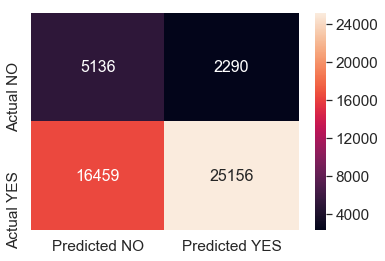

In [89]:
get_confusion_matrix(sgd_tfidf_w2v,X_train_tfidf_w2v,y_train)

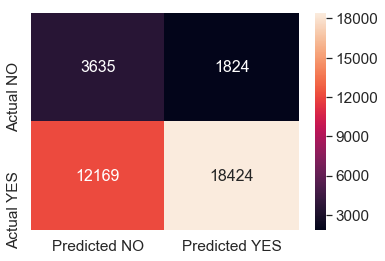

In [90]:
get_confusion_matrix(sgd_tfidf_w2v,X_test_tfidf_w2v,y_test)

<h4> <font color="black">Evaluating Model performance</font></h4> 

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = sgd_tfidf_w2v.predict(X_test_tfidf_w2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 61.187%
Precision on test set: 0.910
Recall on test set: 0.602
F1-Score on test set: 0.725


<h2><font color='blue'>Set 5: categorical, numerical features + Sentiment score + Number of words in title and combined essay </font></h2>   

<h4> <font color="black">Hstacking features</font></h4> 

In [92]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train = hstack((X_train_categories_one_hot, X_train_sub_categories_one_hot,quantity_train, X_train_state_one_hot, X_train_prefix_one_hot, X_train_grade_one_hot, price_train, number_projects_train,essay_size_train,title_size_train,essay_sentiment_train)).tocsr()
X_cv = hstack((X_cv_categories_one_hot, X_cv_sub_categories_one_hot, quantity_cv, X_cv_state_one_hot, X_cv_prefix_one_hot, X_cv_grade_one_hot, price_cv, number_projects_cv,essay_size_cv,title_size_cv,essay_sentiment_cv)).tocsr()
X_test = hstack((X_test_categories_one_hot, X_test_sub_categories_one_hot,quantity_test, X_test_state_one_hot, X_test_prefix_one_hot, X_test_grade_one_hot,price_test, number_projects_test,essay_size_test,title_size_test,essay_sentiment_test)).tocsr()

print('Final matrix')
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

Final matrix
(49041, 105) (49041,)
(24155, 105) (24155,)
(36052, 105) (36052,)


<h4> <font color="black">Hyperparameter tuning</font></h4> 

In [93]:
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas =[0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 5, 10, 20, 50, 100, 500,1000,10000]  #Taking random values of alpha

for i in tqdm(alphas):
    sgd_clf = SGDClassifier(alpha=i, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
           verbose=0, warm_start=False)
    sgd_clf.fit(X_train, y_train)

    y_train_pred = batch_predict(sgd_clf, X_train )    
    y_cv_pred = batch_predict(sgd_clf, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    
for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


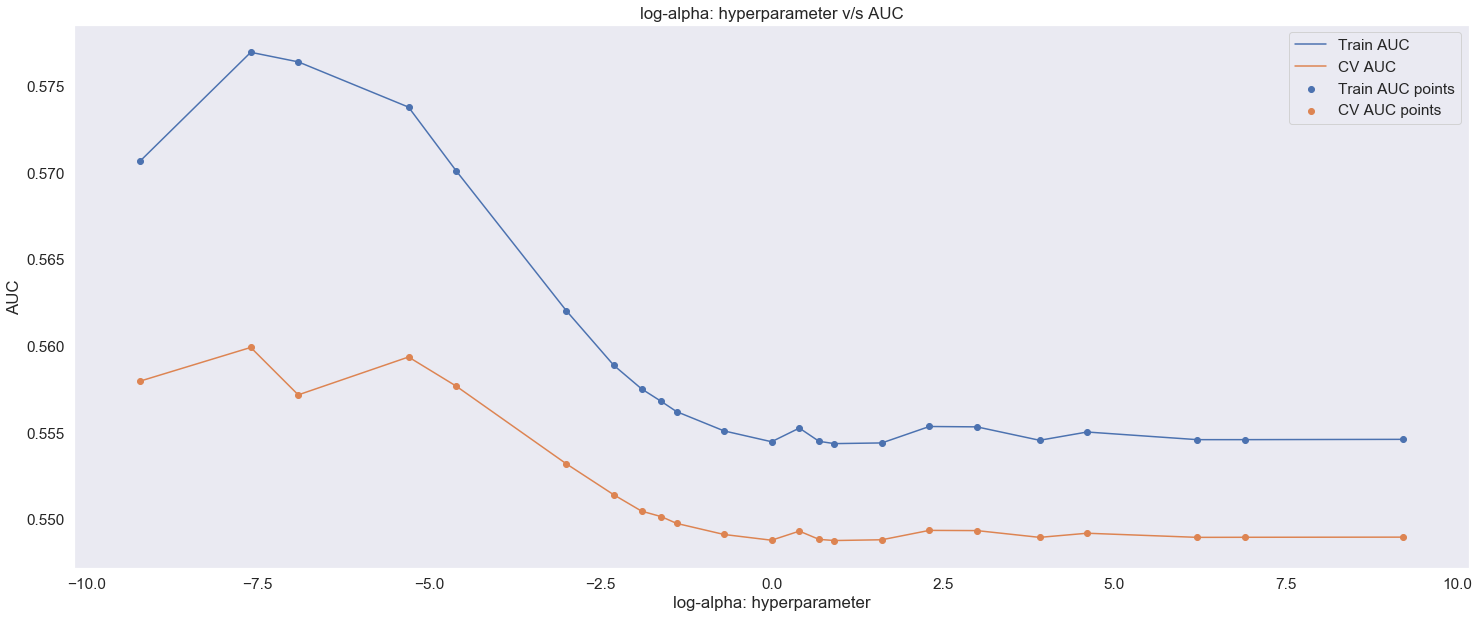

In [94]:
plt.figure(figsize=(25,10))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("log-alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [95]:
optimal_alpha = 0.005

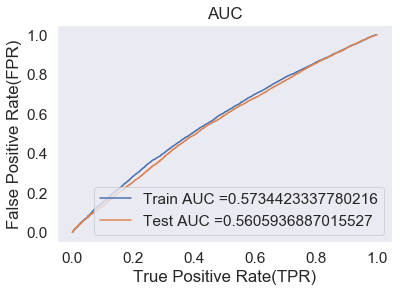

In [96]:

from sklearn.metrics import roc_curve, auc

sgd_clf = SGDClassifier(alpha=optimal_alpha, average=False, class_weight='balanced',
           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
           l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
           n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
          random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False)

sgd_clf.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(sgd_clf, X_train)    
y_test_pred = batch_predict(sgd_clf, X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

Confusion matrix

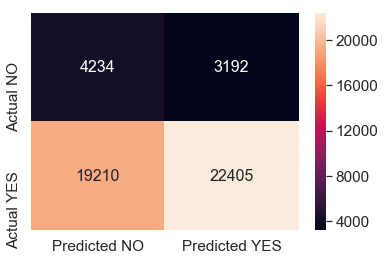

In [97]:
get_confusion_matrix(sgd_clf,X_train,y_train)

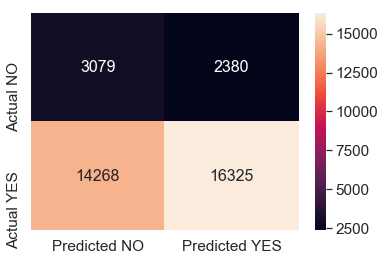

In [98]:
get_confusion_matrix(sgd_clf,X_test,y_test)

<h4> <font color="black">Evaluating Model performance</font></h4> 

In [99]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_pred_new = sgd_clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_new)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_new)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_new)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_new)))

Accuracy on test set: 53.822%
Precision on test set: 0.873
Recall on test set: 0.534
F1-Score on test set: 0.662


## Conclusion: 
### 1. A slight decrease in acuuracy isobeserved when text essay and title are not considered.
### 2. BoW and Tfidf W2V model has performed relatively better than other models.


In [101]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter", "Train AUC","Test AUC","F1 Score","Accuracy on test set"]

x.add_row(["BoW (set 1)",0.005, 0.73, 0.65,0.755,"64.030%"])
x.add_row(["TFIDF (set 2)",0.005, 0.61, 0.58,0.699,"57.531%"])
x.add_row(["AVG W2V (set 3)",0.005, 0.68, 0.68,0.609,"50.241%"])
x.add_row(["TFIDF W2V (set 4)",0.005, 0.70, 0.68, 0.725,"61.187%"])
x.add_row(["- (set 5)",0.005, 0.57, 0.56,0.662,"53.822%"])

print(x)

+-------------------+----------------+-----------+----------+----------+----------------------+
|     Vectorizer    | Hyperparameter | Train AUC | Test AUC | F1 Score | Accuracy on test set |
+-------------------+----------------+-----------+----------+----------+----------------------+
|    BoW (set 1)    |     0.005      |    0.73   |   0.65   |  0.755   |       64.030%        |
|   TFIDF (set 2)   |     0.005      |    0.61   |   0.58   |  0.699   |       57.531%        |
|  AVG W2V (set 3)  |     0.005      |    0.68   |   0.68   |  0.609   |       50.241%        |
| TFIDF W2V (set 4) |     0.005      |    0.7    |   0.68   |  0.725   |       61.187%        |
|     - (set 5)     |     0.005      |    0.57   |   0.56   |  0.662   |       53.822%        |
+-------------------+----------------+-----------+----------+----------+----------------------+
